In [35]:
import os
import cv2
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications.imagenet_utils import decode_predictions, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import random
import time
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img,array_to_img
from IPython.display import clear_output
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
import pandas as pd
from numpy import save

In [2]:
df  = pd.DataFrame()

In [3]:
def get_image_paths(dataset_path , labels_file_path , image_size,image_paths_pickle):
    with open(labels_file_path,"r") as f:
        classes = f.read().split("\n")[:-1]
    class_lbl = {}
    x = 0
    for _class in classes:
        class_lbl[_class] = x
        x=x+1
    labels = []
    image_paths = []
    
    for _class in classes:
        class_data_path = os.path.join(dataset_path ,_class)
        for img in os.listdir(class_data_path):
            image_path = os.path.join(class_data_path ,img)
            image_paths.append(image_path)
            labels.append(class_lbl[_class])

    with open(image_paths_pickle +".pickle", "wb") as f:
        pickle.dump(image_paths , f)
    assert len(image_paths) == len(labels)
    return  np.array(labels),image_paths

In [4]:
lbl, i = get_image_paths('dataset/train', 'dataset/labels.txt', (32,32), 'pickel')

In [5]:
df['img_name'] = i
df['labels'] = lbl
df = df.sample(frac=1).reset_index(drop=True)
df.to_csv('train.csv',index=False)

In [6]:
import gc
gc.collect()

20

In [7]:
df.head()

,img_name,labels
0,dataset/train/dog/0917.png,5
1,dataset/train/cat/2400.png,3
2,dataset/train/cat/0757.png,3
3,dataset/train/truck/3936.png,9
4,dataset/train/automobile/0165.png,1


In [8]:
import gc
gc.collect()

20

In [9]:
#### Data augmentation

In [10]:
image_size = 32
def decode_image(filename, label=None, image_size=(image_size, image_size)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, size = image_size)
    return image, label


def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_contrast(image, lower = 1, upper = 2)
    return image, label

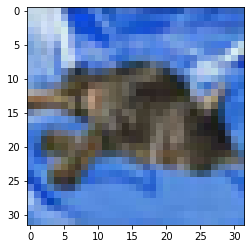

In [11]:
chosen_image = cv2.imread(df.iloc[1,0])[:,:,::-1]
plt.imshow(chosen_image)

In [12]:
horizontal_flipped = tf.image.flip_left_right(chosen_image)
vertically_flipped = tf.image.flip_up_down(chosen_image)
adjusted_saturation = tf.image.adjust_saturation(chosen_image, saturation_factor = 2)
adjusted_brightness = tf.image.adjust_brightness(chosen_image, delta = 0.3)
adjusted_contrast = tf.image.adjust_contrast(chosen_image, contrast_factor = 2)

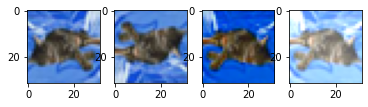

In [13]:
fig, axs = plt.subplots(1,4)
axs[0].imshow(horizontal_flipped)
axs[1].imshow(vertically_flipped)
axs[2].imshow(adjusted_saturation)
axs[3].imshow(adjusted_brightness)

In [14]:
EPOCHS = 20
BATCH_SIZE = 32
AUTO = tf.data.experimental.AUTOTUNE

In [15]:
### make mini batch

In [16]:
def get_data(training_data,validation_data):
    labels = tf.keras.utils.to_categorical(training_data.iloc[:,1], num_classes=10, dtype='float32')
    train_dataset_fold = (
        tf.data.Dataset
        .from_tensor_slices((training_data.iloc[:,0], labels))
        .map(decode_image, num_parallel_calls=AUTO)
        .map(data_augment, num_parallel_calls=AUTO)
        .repeat()
        .shuffle(512)
        .batch(BATCH_SIZE)
        .prefetch(AUTO))

    val_labels = tf.keras.utils.to_categorical(validation_data.iloc[:,1], num_classes=10, dtype='float32')
    valid_dataset_fold = (
        tf.data.Dataset
        .from_tensor_slices((validation_data.iloc[:,0], val_labels))
        .map(decode_image, num_parallel_calls=AUTO)
        .batch(BATCH_SIZE)
        .cache()
        .prefetch(AUTO))
    
    return train_dataset_fold,valid_dataset_fold

In [17]:
## Learning rate is the rate at which our model learns -> we are changing the learning rate according to the loss and having a track on change of learning rate 

Learning rate schedule: 1e-05 to 5e-05 to 1.06e-05


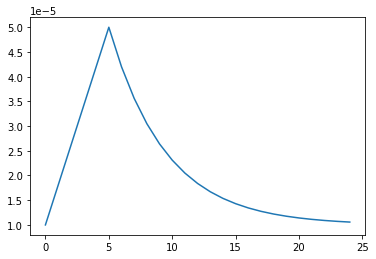

In [18]:
def build_lrfn(lr_start=0.00001, lr_max=0.00005, 
               lr_min=0.00001, lr_rampup_epochs=5, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max
    
    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
rng = [i for i in range(25)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [19]:
## check points and inter midiate save

In [20]:
STEPS_PER_EPOCH = lbl.shape[0] // BATCH_SIZE
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('StratifiedFold.h5', monitor='val_loss', verbose=2, save_best_only=True)

In [21]:
# model selection

In [26]:
import efficientnet.tfkeras as efn
import tensorflow.keras.layers as L
def get_model():
    strategy = tf.distribute.get_strategy()
    with strategy.scope():
        model = keras.Sequential()
        model.add(Conv2D(64, kernel_size = (3,3) , strides = (1,1),activation='relu',input_shape=(32,32,3)))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
        model.add(Dropout(0.3))

        model.add(Conv2D(128,kernel_size = (3,3), strides = (1, 1), activation='relu',padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
        model.add(Dropout(0.2))

        model.add(Conv2D(256,kernel_size = (5,5), strides = (1, 1), activation='relu',padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
        model.add(Dropout(0.2))

        model.add(Conv2D(512,kernel_size = (5,5), strides = (1, 1), activation='relu',padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
        model.add(Dropout(0.2))

        model.add(Flatten())

        model.add(Dense(128, activation='relu'))
        model.add(BatchNormalization())

        model.add(Dense(256, activation='relu',name  = 'f1'))
        model.add(BatchNormalization())

        model.add(Dense(512, activation='relu'))
        model.add(BatchNormalization())

        model.add(Dense(1024, activation='relu' , name = 'f2'))
        model.add(BatchNormalization())

        model.add(Dense(10,activation = 'softmax'))
        model.compile(
            optimizer='adam',
            loss = 'categorical_crossentropy', #for multiple categories and classification problem we can use categorical-
            metrics=[tf.keras.metrics.AUC()])  # -cross entropy as loss 
                                               # Computing the approximate AUC (Area under the curve) via a Riemann sum.
    return model

In [23]:
def train(training_dataset_fold,valid_dataset_fold):
    model_fold_1 = get_model()
    history_1 = model_fold_1.fit(training_dataset_fold,
                        epochs=EPOCHS,
                        callbacks=[model_checkpoint,lr_schedule],
                        steps_per_epoch=STEPS_PER_EPOCH,
                        validation_data = valid_dataset_fold
                        )

In [24]:
### Kfolds -> Split dataset into k consecutive folds 

In [27]:
kf = KFold(n_splits = 2)

for train_index, val_index in kf.split(np.zeros(len(df.labels)),df.labels):
    training_data = df.iloc[train_index]
    validation_data = df.iloc[val_index]
    training_dataset_fold  , valid_dataset_fold = get_data(training_data , validation_data)
    del training_data,validation_data
    gc.collect()
    train(training_dataset_fold,valid_dataset_fold)
    
    


Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
1562/1562 [==============================] - 724s 462ms/step - loss: 2.7644 - auc: 0.5485 - val_loss: 2.5436 - val_auc: 0.6172

Epoch 00001: val_loss improved from inf to 2.54364, saving model to StratifiedFold.h5
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 1.8000000000000004e-05.
1562/1562 [==============================] - 762s 488ms/step - loss: 2.3464 - auc: 0.6469 - val_loss: 2.2353 - val_auc: 0.6814

Epoch 00002: val_loss improved from 2.54364 to 2.23528, saving model to StratifiedFold.h5
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
1562/1562 [==============================] - 654s 419ms/step - loss: 2.1190 - auc: 0.7189 - val_loss: 2.0460 - val_auc: 0.7381

Epoch 00003: val_loss improved from 2.23528 to 2.04596, saving model to StratifiedFold.h5
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 3.

KeyboardInterrupt: 

In [29]:
model = keras.models.load_model('StratifiedFold.h5')

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        7

In [31]:
feat_extractor_256 = Model(inputs=model.input,outputs=model.get_layer("f1").output)
feat_extractor_1024 = Model(inputs=model.input,outputs=model.get_layer("f2").output)

feat_extractor_256.summary()
feat_extractor_1024.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 128)       512   

In [36]:
import numpy as np
import matplotlib.pyplot as plt

def load_image(path):
    img = image.load_img(path,target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x,axis=0)
    x = preprocess_input(x)
    return img,x

In [33]:
images_path = 'dataset/train'
image_extensions=['.jpg','.png','.jpeg']
max_num_images = 100000 #keep the number less than 30 if running on cpu for faster results
tick = time.time()
# dp has the root directory,dn has the sub directories and filenames has the file name

images = [os.path.join(dp,f) for dp,dn,filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
if max_num_images<len(images):
  #get random images from the image paths
  images = [images[i] for i in sorted(random.sample(range(len(images)),max_num_images))]
print("keeping %d images to analyze" %len(images))

keeping 50000 images to analyze


In [ ]:
tic = time.time()
features = []
for i, image_path in enumerate(images):
    if i%500 == 0:
        toc = time.time()
        elap = toc-tic;
        print("analyzing image %d / %d. Time taken : %4.4f seconds"%(i,len(images),elap))
        tic= time.time()
    img,x = load_image(image_path)
    feat1 = feat_extractor_256.predict(x)[0]
    feat2 = feat_extractor_1024.predict(x)[0]
    feat1 = feat1.reshape(-1,1)
    feat2 = feat2.reshape(-1,1)
    feat = np.vstack((feat1,feat2))
    features.append(feat)
print('finished extracting features for %d images' % len(images))

analyzing image 0 / 50000. Time taken : 0.0004 seconds
analyzing image 500 / 50000. Time taken : 57.5143 seconds
analyzing image 1000 / 50000. Time taken : 60.1636 seconds
analyzing image 1500 / 50000. Time taken : 49.4006 seconds
analyzing image 2000 / 50000. Time taken : 51.4924 seconds
analyzing image 2500 / 50000. Time taken : 50.8399 seconds
analyzing image 3000 / 50000. Time taken : 50.9855 seconds
analyzing image 3500 / 50000. Time taken : 58.6763 seconds
analyzing image 4000 / 50000. Time taken : 58.5866 seconds
analyzing image 4500 / 50000. Time taken : 52.2567 seconds
analyzing image 5000 / 50000. Time taken : 57.6467 seconds
analyzing image 5500 / 50000. Time taken : 47.1896 seconds
analyzing image 6000 / 50000. Time taken : 50.5906 seconds
analyzing image 6500 / 50000. Time taken : 47.6200 seconds


In [28]:
features = np.array(features)

In [29]:
features = features.reshape(-1, 1280,)

In [30]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=1024)
pca.fit(features)

PCA(copy=True, iterated_power='auto', n_components=1024, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [31]:
pca_features = pca.transform(features)

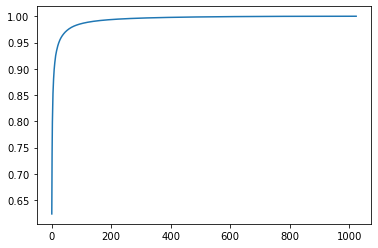

In [32]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [ ]:
# cosine distance to measure similarity

In [33]:
from scipy.spatial import distance

def get_closest_images(query_image_idx, num_results=20):     #num_results is the number of top similar images for query
    distances = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

In [34]:
def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

Text(0.5, 1.0, 'Result images')

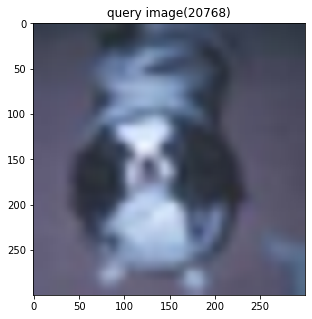

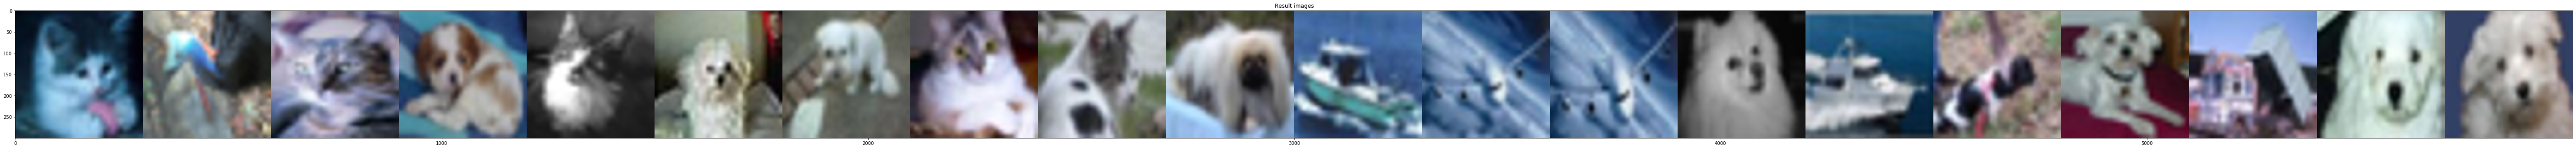

In [36]:
import random
query_image_idx = int(len(images)*random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx],300)
results_image = get_concatenated_images(idx_closest,300)

plt.figure(figsize=(5,5))
plt.imshow(query_image)
plt.title("query image(%d)" %query_image_idx)

plt.figure(figsize=(100,220))
plt.imshow(results_image)
plt.title("Result images")